In [1]:
from __future__ import division
import numpy as np
import pandas as pd
from glob import glob
from os.path import join, basename, exists
from os import makedirs
import matplotlib.pyplot as plt
from nilearn import input_data, datasets, plotting, regions
from nilearn.image import concat_imgs
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import bct
from matplotlib import pyplot as plt
%matplotlib inline

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", Deprec

In [2]:
def betweenness_wei(G):
    '''
    Node betweenness centrality is the fraction of all shortest paths in
    the network that contain a given node. Nodes with high values of
    betweenness centrality participate in a large number of shortest paths.
    Parameters
    ----------
    L : NxN np.ndarray
        directed/undirected weighted connection matrix
    Returns
    -------
    BC : Nx1 np.ndarray
        node betweenness centrality vector
    Notes
    -----
       The input matrix must be a connection-length matrix, typically
        obtained via a mapping from weight to length. For instance, in a
        weighted correlation network higher correlations are more naturally
        interpreted as shorter distances and the input matrix should
        consequently be some inverse of the connectivity matrix.
       Betweenness centrality may be normalised to the range [0,1] as
        BC/[(N-1)(N-2)], where N is the number of nodes in the network.
    '''
    n = len(G)
    BC = np.zeros((n,))  # vertex betweenness

    for u in range(n):
        D = np.tile(np.inf, (n,))
        D[u] = 0  # distance from u
        NP = np.zeros((n,))
        NP[u] = 1  # number of paths from u
        S = np.ones((n,), dtype=bool)  # distance permanence
        P = np.zeros((n, n))  # predecessors
        Q = np.zeros((n,), dtype=int)  # indices
        q = n - 1  # order of non-increasing distance

        G1 = G.copy()
        V = [u]
        while True:
            S[V] = 0  # distance u->V is now permanent
            G1[:, V] = 0  # no in-edges as already shortest
            for v in V:
                Q[q] = v
                q -= 1
                W, = np.where(G1[v, :])  # neighbors of v
                for w in W:
                    Duw = D[v] + G1[v, w]  # path length to be tested
                    if Duw < D[w]:  # if new u->w shorter than old
                        D[w] = Duw
                        NP[w] = NP[v]  # NP(u->w) = NP of new path
                        P[w, :] = 0
                        P[w, v] = 1  # v is the only predecessor
                    elif Duw == D[w]:  # if new u->w equal to old
                        NP[w] += NP[v]  # NP(u->w) sum of old and new
                        P[w, v] = 1  # v is also predecessor

            if D[S].size == 0:
                break  # all nodes were reached
            if np.isinf(np.min(D[S])):  # some nodes cannot be reached
                Q[:q + 1], = np.where(np.isinf(D))  # these are first in line
                break
            V, = np.where(D == np.min(D[S]))

        DP = np.zeros((n,))
        for w in Q[:n - 1]:
            BC[w] += DP[w]
            for v in np.where(P[w, :])[0]:
                DP[v] += (1 + DP[w]) * NP[v] / NP[w]

    return BC

In [5]:
#choose your atlas and either fetch it from Nilearn using one of the the 'datasets' functions
laird_2011_icns = '/home/data/nbc/anxiety-physics/17-networks-combo-ccn-5.14.nii.gz'

In [6]:
#or load it in from a local file
#we're interested in 3, 12, and 14
#add labels for the parcellation
labels = ['limbic', 'orbitofrontal', 'basal ganglia', 'salience', 'hunger', 
          'motor learning', 'frontoparietal', 'hand', 'motor execution', 'higher order visual', 
          'lateral visual', 'medial visual', 'default mode',' cerebellum', 'central executive', 
          'auditory', 'mouth']

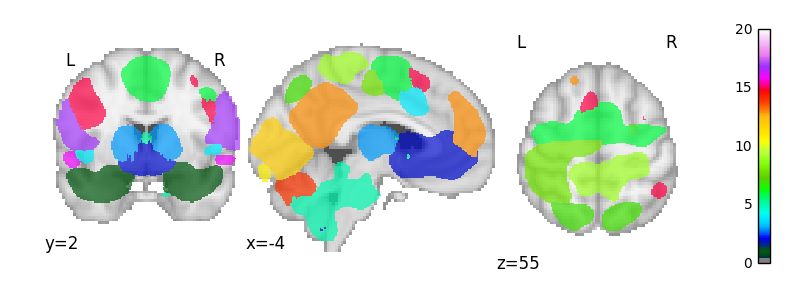

In [7]:
plotting.plot_roi(laird_2011_icns, cut_coords=(-4, 2, 55), colorbar=True, vmin=0, vmax=20, draw_cross=False)
plotting.show()
#dmn is 7 (6 if 0-idx)
#sal is 4 (3 if 0-idx)
#cen is 3 (2 if 0-idx)

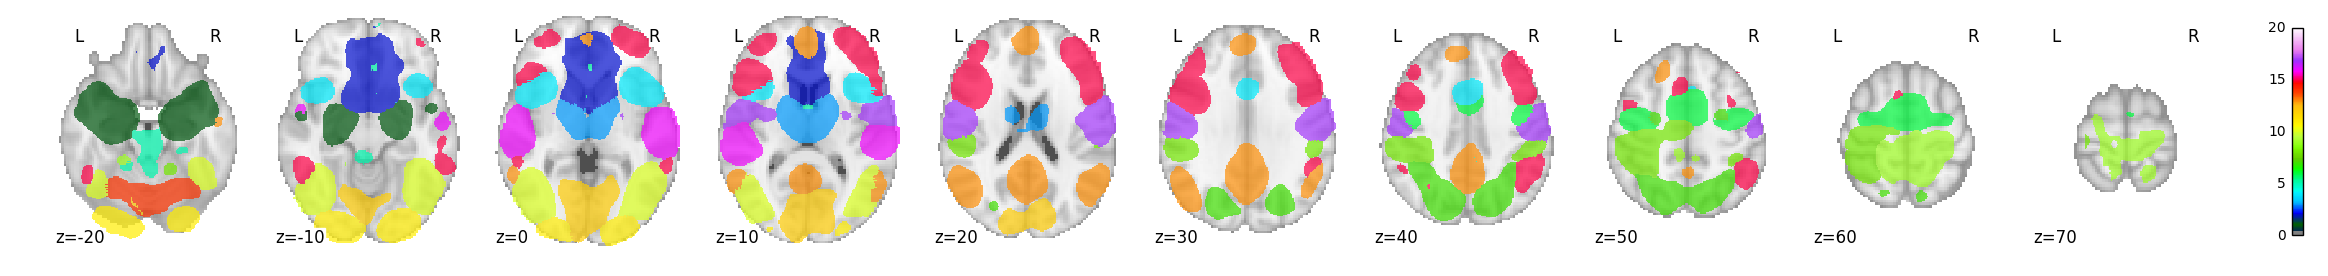

In [8]:
plotting.plot_roi(laird_2011_icns, cut_coords=(-20, -10, 0, 10, 20, 30, 40, 50, 60, 70), 
                  display_mode='z', colorbar=True, vmin=0, vmax=20, draw_cross=False)

In [9]:
#create your masker objects 
#(this is how to pull timeseries from niftis into arrays, based on your parcellations scheme)
#one masker to pull out one signal per network (average of voxelwise signals across the network)
network_masker = input_data.NiftiLabelsMasker(laird_2011_icns, standardize=True)
#one masker to pull out one signal per region (if applicable)
#region_masker = input_data.NiftiLabelsMasker('/Users/Katie/Dropbox/Data/salience-anxiety-graph-theory/relabeled_yeo_atlas7_gt100.nii.gz', standardize=True)

In [18]:
#all of the pre subjects
subjects = ['101', '102', '103', '104', '106', '107', '108', '110', '212', '213',
            '214', '215', '216', '217', '218', '219', '320', '321', '322', '323',
            '324', '325', '327', '328', '329', '330', '331', '332', '333', '334',
            '335', '336', '337', '338', '339', '340', '341', '342', '343', '344',
            '345', '346', '347', '348', '349', '350', '451', '452', '453', '455',
            '456', '457', '458', '459', '460', '462', '463', '464', '465', '467',
            '468', '469', '470', '502', '503', '571', '572', '573', '574', '575',
            '577', '578', '579', '580', '581', '582', '584', '585', '586', '587',
            '588', '589', '590', '591', '592', '593', '594', '595', '596', '597',
            '598', '604', '605', '606', '607', '608', '609', '610', '611', '612',
            '613', '614', '615', '616', '617', '618', '619', '620', '621', '622',
            '623', '624', '625', '626', '627', '628', '629', '630', '631', '633',
            '634']

#the following subjects have  pre and post scans :)
subjects = ["101", "102", "103", "104", "106", "107", "108", "110", "212",
            "214", "215", "216", "217", "218", "219", "320", "321", "323",
            "324", "325", "327", "328", "330", "331", "333", "334", "336",
            "337", "338", "339", "340", "341", "342", "343", "345", "346",
            "347", "348", "349", "350", "451", "453", "455", "458", "459",
            "460", "462", "463", "464", "467", "468", "469", "470", "502",
            "503", "571", "572", "573", "574", "577", "578", "581", "582",
            "584", "586", "588", "589", "591", "592", "593", "594", "595",
            "596", "597", "598", "604", "605", "606", "607", "608", "609",
            "610", "612", "613", "614", "615", "617", "618", "619", "620",
            "621", "622", "623", "624", "625", "626", "627", "629", "630",
            "631", "633", "634"]
#for testing
subjects = ['102', '103', '104']

data_dir = '/home/data/nbc/physics-learning/data/pre-processed'
#data_dir = '/Users/Katie/Dropbox/Projects/physics-anxiety/'
#pre_dir = '/home/data/nbc/anxiety-physics/pre'
#post_dir = '/home/data/nbc/anxiety-physics/post'
pre_dir = '/Users/Katie/Dropbox/Projects/physics-anxiety/data/pre'
post_dir = '/Users/Katie/Dropbox/Projects/physics-anxiety/data/post'
#sink_dir = '/home/data/nbc/anxiety-physics/output'
sink_dir = '/Users/Katie/Dropbox/Projects/physics-anxiety/data/out'

directories = [pre_dir, post_dir]
sessions = ['pre', 'post']

#choose your connectivity metric from "correlation", "partial correlation", "tangent", "covariance", "precision"
connectivity_metric = 'correlation'

#determine the range of thresholds across which graph theoretic measures will be integrated
#threshold of 0.1 means the top 10% of connections will be retained
thresh_range = np.arange(0.1, 1, 0.1)

laird_2011_icns = '/home/data/nbc/anxiety-physics/17-networks-combo-ccn-5.14.nii.gz'

network_masker = input_data.NiftiLabelsMasker(laird_2011_icns, standardize=True)

In [86]:
subjects = ["101", "102", "103", "104", "106", "107", "108", "110", "212",
            "214", "215", "216", "217", "218", "219", "320", "321", "323",
            "324", "325", "327", "328", "330", "331", "333", "334", "336",
            "337", "338", "339", "340", "341", "342", "343", "345", "346",
            "347", "348", "349", "350", "451", "453", "455", "458", "459",
            "460", "462", "463", "464", "467", "468", "469", "470", "502",
            "503", "571", "572", "573", "574", "577", "578", "581", "582",
            "584", "586", "588", "589", "591", "592", "593", "594", "595",
            "596", "597", "598", "604", "605", "606", "607", "608", "609",
            "610", "612", "613", "614", "615", "617", "618", "619", "620",
            "621", "622", "623", "624", "625", "626", "627", "629", "630",
            "631", "633", "634"]
#subjects = ['102', '103', '104']

data_dir = '/home/data/nbc/physics-learning/data/pre-processed'
pre_dir = '/home/data/nbc/anxiety-physics/pre'
post_dir = '/home/data/nbc/anxiety-physics/post'
sink_dir = '/home/data/nbc/anxiety-physics/output'
#data_dir = '/Users/Katie/Dropbox/Data'
#work_dir = '/Users/Katie/Dropbox/Data/salience-anxiety-graph-theory'
directories = [pre_dir, post_dir]
sessions = ['pre', 'post']

connectivity_metric = 'correlation'

#determine the range of thresholds across which graph theoretic measures will be integrated
#threshold of 0.1 means the top 10% of connections will be retained
thresh_range = np.arange(0.1, 1, 0.1)

In [87]:
df = pd.DataFrame({'efficiency pre': np.empty([len(subjects),], dtype=float),
                   'clustering pre': np.empty([len(subjects),], dtype=float),
                   'efficiency post': np.empty([len(subjects),], dtype=float),
                   'clustering post': np.empty([len(subjects),], dtype=float),
                   'dmn-sn pre': np.empty([len(subjects),], dtype=float), 
                   'sn-cen pre': np.empty([len(subjects),], dtype=float), 
                   'cen-dmn pre': np.empty([len(subjects),], dtype=float), 
                   'dmn-sn post': np.empty([len(subjects),], dtype=float), 
                   'sn-cen post': np.empty([len(subjects),], dtype=float), 
                   'cen-dmn post': np.empty([len(subjects),], dtype=float)}, 
                  index=subjects)
for session in sessions:
    print(session)
    gl_eff = {}
    clustc = {}
    for s in subjects:
        print(s)
        if not exists(join(sink_dir, session, s)):
            makedirs(join(sink_dir, session, s))
        fmri_file = join(directories[i], '{0}_filtered_func_data_mni.nii.gz'.format(s))
        print(fmri_file)
        
        confounds = join(sink_dir, session, s, '{0}_confounds.txt'.format(s))
        print(confounds)
        
        #create correlation matrix from PRE resting state files
        network_time_series = network_masker.fit_transform (fmri_file, confounds)
        network_time_series.shape
        #region_time_series = region_masker.fit_transform (fmri_file, confounds)
        correlation_measure = ConnectivityMeasure(kind=connectivity_metric)
        
        network_correlation_matrix = correlation_measure.fit_transform([network_time_series])[0]
        #region_correlation_matrix = correlation_measure.fit_transform([region_time_series])[0]
        #np.savetxt(join(sink_dir, sessions[i], s, '{0}_region_corrmat_Yeo7.csv'.format(s)), region_correlation_matrix, delimiter=",")
        np.savetxt(join(sink_dir, session, s, '{0}_network_corrmat_Laird2011.csv'.format(s)), network_correlation_matrix, delimiter=",")
        
        df.at[s, 'dmn-sn {0}'.format(session)] = network_correlation_matrix[3,12]
        df.at[s, 'sn-cen {0}'.format(session)] = network_correlation_matrix[3,14]
        df.at[s, 'cen-dmn {0}'.format(session)] = network_correlation_matrix[14,12]
        
        ge = []
        cc = []

        #talking with Kim:
        #start threhsolding (least conservative) at the lowest threshold where you lose your negative connection weights
        #steps of 5 or 10 percent
        #citation for integrating over the range is likely in the Fundamentals of Brain Network Analysis book
        #(http://www.danisbassett.com/uploads/1/1/8/5/11852336/network_analysis_i__ii.pdf)
        #typically done: make sure your metric's value is stable across your range of thresholds
        #the more metrics you use, the more you have to correct for multiple comparisons
        #make sure this is hypothesis-driven and not fishing

        for p in thresh_range:
            ntwk_corrmat_thresh = bct.threshold_proportional(network_correlation_matrix, p, copy=True)
            #measures of interest here
            #global efficiency
            le = bct.efficiency_wei(ntwk_corrmat_thresh)

            #clustering coefficient
            c = bct.clustering_coef_wu(ntwk_corrmat_thresh)

            ge.append(le)
            cc.append(np.average(c))

        
        df.at[s, 'efficiency {0}'.format(session)] = np.trapz(ge, dx=0.1)
        df.at[s, 'clustering {0}'.format(session)] = np.trapz(cc, dx=0.1)
        
        #ntwk_df.columns = ['total positive', 'total negative', 'efficiency', 'path length', 'modularity']

        #cc_df = pd.Series(cc, name="clustering coefficient").T
        #ntwk_wise_df.columns = ['betweenness', 'degree', 'positive weights', 'negative weights',
        #                                                   'community index', 'clustering coefficient']
        #df = pd.concat([ge_df, cc_wise_df], axis=1)
        #df.to_csv(join(sink_dir, sessions[i], s, '{0}_out.csv'.format(s)), sep=',')
df.to_csv(join(sink_dir, 'out.csv'))

pre
101
/home/data/nbc/anxiety-physics/pre/101_filtered_func_data_mni.nii.gz
/home/data/nbc/anxiety-physics/output/pre/101/101_confounds.txt
102
/home/data/nbc/anxiety-physics/pre/102_filtered_func_data_mni.nii.gz
/home/data/nbc/anxiety-physics/output/pre/102/102_confounds.txt
103
/home/data/nbc/anxiety-physics/pre/103_filtered_func_data_mni.nii.gz
/home/data/nbc/anxiety-physics/output/pre/103/103_confounds.txt
104
/home/data/nbc/anxiety-physics/pre/104_filtered_func_data_mni.nii.gz
/home/data/nbc/anxiety-physics/output/pre/104/104_confounds.txt
106
/home/data/nbc/anxiety-physics/pre/106_filtered_func_data_mni.nii.gz
/home/data/nbc/anxiety-physics/output/pre/106/106_confounds.txt
107
/home/data/nbc/anxiety-physics/pre/107_filtered_func_data_mni.nii.gz
/home/data/nbc/anxiety-physics/output/pre/107/107_confounds.txt
108
/home/data/nbc/anxiety-physics/pre/108_filtered_func_data_mni.nii.gz
/home/data/nbc/anxiety-physics/output/pre/108/108_confounds.txt
110
/home/data/nbc/anxiety-physics/pr

In [75]:
df = pd.DataFrame({'efficiency pre': np.empty([len(subjects),], dtype=float),
                   'clustering pre': np.empty([len(subjects),], dtype=float),
                   'efficiency post': np.empty([len(subjects),], dtype=float),
                   'clustering post': np.empty([len(subjects),], dtype=float)}, 
                  index=subjects)

In [76]:
df.at['106', 'efficiency pre'] = 0.2

In [85]:
df

,cen-dmn post,cen-dmn pre,clustering post,clustering pre,dmn-sn post,dmn-sn pre,efficiency post,efficiency pre,sn-cen post,sn-cen pre
102,0.149842,0.168978,0.205864,0.204868,0.110552,0.112665,0.212332,0.214540,0.353858,0.360086
103,0.542552,0.530280,0.228499,0.226769,0.461298,0.467790,0.225021,0.220538,0.650993,0.648282
104,-0.013433,-0.012152,0.160447,0.167550,0.094821,0.068846,0.075053,0.088125,0.261183,0.281490


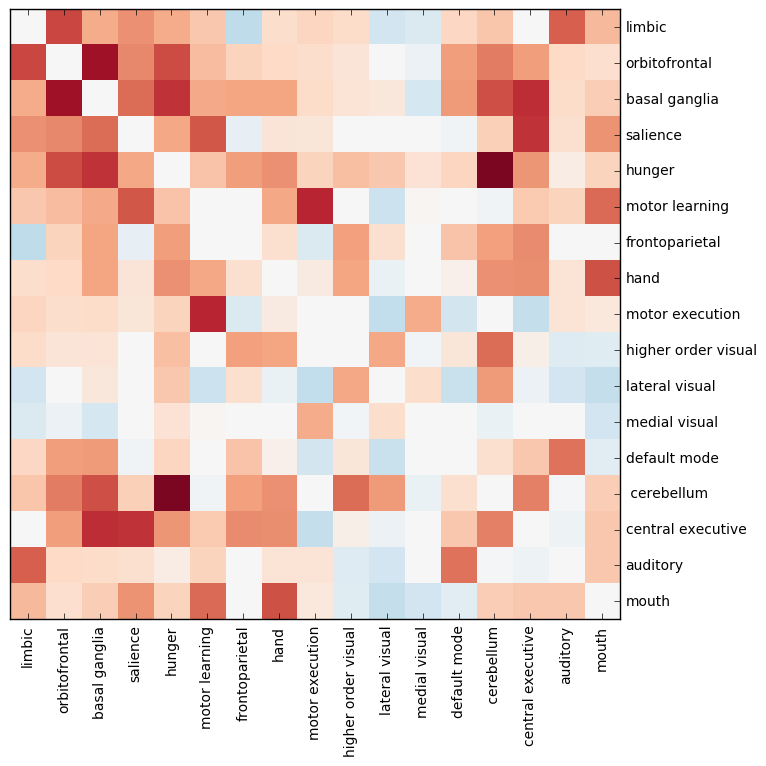

In [17]:
from nilearn.connectome import ConnectivityMeasure

# Plot the correlation matrix
import numpy as np
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
# Mask the main diagonal for visualization:
np.fill_diagonal(ntwk_corrmat_thresh, 0)

plt.imshow(ntwk_corrmat_thresh, interpolation="nearest", cmap="RdBu_r",
           vmax=0.8, vmin=-0.8)

# Add labels and adjust margins
x_ticks = plt.xticks(range(len(labels)), labels[:], rotation=90)
y_ticks = plt.yticks(range(len(labels)), labels[:])
plt.gca().yaxis.tick_right()
plt.subplots_adjust(left=.01, bottom=.3, top=.99, right=.62)